In [1]:
# import lib
# ===========================================================
import csv
import pandas as pd
from datascience import *
import numpy as np
import random
import time
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
import collections
import math
import sys
from tqdm import tqdm
from time import sleep

In [2]:
# Initialize useful data
# with open('clinvar_conflicting_clean.csv', 'r') as f:
#     reader = csv.reader(f)
#     temp_rows = list(reader)
df = pd.read_csv('clinvar_conflicting_clean.csv', low_memory=False)
# columns_to_change = ['ORIGIN', 'EXON', 'INTRON', 'STRAND', 'LoFtool', 'CADD_PHRED', 'CADD_RAW', 'BLOSUM62']
# df[['CLNVI', 'MC', 'SYMBOL', 'Feature_type', 'Feature', 'BIOTYPE', 
#  'cDNA_position', 'CDS_position', 'Protein_position', 'Amino_acids', 'Codons', 
#  'BAM_EDIT', 'SIFT', 'PolyPhen']] = df[['CLNVI', 'MC', 'SYMBOL', 'Feature_type', 'Feature', 'BIOTYPE', 
#  'cDNA_position', 'CDS_position', 'Protein_position', 'Amino_acids', 'Codons', 
#  'BAM_EDIT', 'SIFT', 'PolyPhen']].fillna(value="null")


df = df.fillna(value=0)
df_zero = df.loc[df['CLASS'] == 0]
df_zero = df_zero.sample(n=10000)
df_one = df.loc[df['CLASS'] == 1]
df_one = df_one.sample(n=10000)
df = pd.concat([df_zero, df_one])


df = df.sample(n = df.shape[0])
all_rows = df.values.tolist()
row_num = len(all_rows)
df.head()

,CHROM,POS,REF,ALT,AF_ESP,AF_EXAC,AF_TGP,CLNDISDB,CLNDN,CLNHGVS,...,Codons,STRAND,BAM_EDIT,SIFT,PolyPhen,LoFtool,CADD_PHRED,CADD_RAW,BLOSUM62,CLASS
13553,3,30713674,A,G,0.0269,0.00764,0.0232,"MedGen:C0024796,OMIM:154700,Orphanet:ORPHA558,...",Marfan_syndrome|Loeys-Dietz_syndrome|Thoracic_...,NC_000003.11:g.30713674A>G,...,ctA/ctG,1.0,0,0,0,0.06010,2.363,-0.023857,0.0,0
30013,9,140052867,T,C,0.0002,0.00006,0.0000,"MedGen:C3280282,OMIM:614254|MedGen:CN169374",Neurodevelopmental_disorder_with_or_without_hy...,NC_000009.11:g.140052867T>C,...,acT/acC,1.0,0,0,0,0.09860,0.044,-0.796316,0.0,1
55011,17,62034609,G,A,0.0147,0.01722,0.0186,"MedGen:C0221055,OMIM:168300|MedGen:C0238358,Or...",Paramyotonia_congenita_of_von_Eulenburg|Hypoka...,NC_000017.10:g.62034609G>A,...,atC/atT,-1.0,0,0,0,0.00572,14.840,1.774353,0.0,0
11491,2,189870953,C,A,0.0000,0.00043,0.0010,"MedGen:C0268338,OMIM:130050,Orphanet:ORPHA286,...","Ehlers-Danlos_syndrome,_type_4|not_specified",NC_000002.11:g.189870953C>A,...,Ctt/Att,1.0,OK,tolerated,probably_damaging,0.02070,26.100,5.455760,2.0,1
47893,16,16295957,T,C,0.0000,0.00000,0.0000,"MedGen:C0033847,OMIM:264800,Orphanet:ORPHA758,...",Pseudoxanthoma_elasticum|not_specified,NC_000016.9:g.16295957T>C,...,tcA/tcG,-1.0,OK,0,0,0.01940,3.317,0.072559,0.0,1


In [3]:
# Decision stump part for Adaboost
# ===========================================================
def is_numeric(value):
    return isinstance(value, int) or isinstance(value, float)

# === LeafNode is the prediction result of this branch ===
class LeafNode:
    def __init__(self, rows):
        labels = [row[-1] for row in rows]
#         labels = []
#         self.one_idx = []
#         self.zero_idx = []
#         for i in range(len(rows)):
#             row = rows[i]
#             labels.append(row[-1])
#             if row[-1] == 1:
#                 self.one_idx.append(i)
#             else:
#                 self.zero_idx.append(i)
        self.prediction = collections.Counter(labels)
        
# === DecisionNode is an attribute / question used to partition the data ===
class DecisionNode:
    def __init__(self, question = None, left_branch = None, right_branch = None):
        self.question = question
        self.left_branch = left_branch
        self.right_branch = right_branch
    
class DecisionStump:
    def __init__(self, training_attribute, training_data, height, method = "CART"):
        self.attribute = training_attribute     # takein attribute and data separately
        self.train = training_data
        self.height = height
        self.row_num = len(self.train)
        self.column_num = len(self.attribute)
        self.method = method.upper()            # convert to upper case for general use
        self.significance = 0
        if self.method not in ["C4.5", "CART", "HYBRID"]:
            print("Error: Please choose a valid method! from: [C4.5, CART, HYBRID]")
            return None
        
        # train decision stump
        self.root = self.build_stump(self.train, 1)
        
        # count ACC classifications and mis classifications to update weights
        self.accclassify_idx = []
        self.misclassify_idx = []
        # Only after DecisionStump trained, can we know which rows are misclassified 
        # Walk down the decision stump to collect all misclassification indices
        
#         if self.root.left_branch.prediction.get(1, 0) > self.root.left_branch.prediction.get(0, 0):
#             # then consider the prediction of this leaf node as 1: 1 -> correct, 0 -> misclassify
#             self.accclassify_idx += self.root.left_branch.one_idx
#             self.misclassify_idx += self.root.left_branch.zero_idx
#         else:
#             # then consider the prediction of this leaf node as 0: 0 -> correct, 1 -> misclassify
#             self.accclassify_idx += self.root.left_branch.zero_idx
#             self.misclassify_idx += self.root.left_branch.one_idx
#         if self.root.right_branch.prediction.get(1, 0) > self.root.right_branch.prediction.get(0, 0):
#             # then consider the prediction of this leaf node as 1: 1 -> correct, 0 -> misclassify
#             self.accclassify_idx += self.root.right_branch.one_idx
#             self.misclassify_idx += self.root.right_branch.zero_idx
#         else:
#             # then consider the prediction of this leaf node as 0: 0 -> correct, 1 -> misclassify
#             self.accclassify_idx += self.root.right_branch.zero_idx
#             self.misclassify_idx += self.root.right_branch.one_idx
    
    def uniq_val(self, column):
        return set([self.train[i][column] for i in range(len(self.train))])
    
    # when raising a question.
    # if it's a categorical attribute, we simply iterate all categories
    # if it's a numeric attribute, we iterate the set of possible numeric values 
    class Question:
        def __init__(self, column, ref_value, attribute):
            self.column = column
            self.ref_value = ref_value if ref_value else "None"
            self.attri = attribute

        def match(self, row):
            if is_numeric(self.ref_value):
                try:
                    return row[self.column] >= self.ref_value
                except:
                    print("Error occured in ", row)
                    return True
            else:
                return row[self.column] == self.ref_value

        def __repr__(self):
            operand = ">=" if is_numeric(self.ref_value) else "=="
            return "Is %s %s %s?" % (self.attri[self.column], operand, str(self.ref_value))
    
    # === Method 1 - C4.5 ===
    def entropy(self, rows):
        # === Bits used to store the information ===
        labels = [row[-1] for row in rows]
        frequency = collections.Counter(labels).values()
        pop = sum(frequency)
        H = 0
        for f in frequency:
            p = f / pop
            H -= p * math.log(p, 2)
        return H
    
    # === Method 2 - CART ===
    def gini(self, rows):
        # === Probability of misclassifying any of your label, which is impurity ===
        labels = [row[-1] for row in rows]
        frequency = collections.Counter(labels).values()
        pop = sum(frequency)
        gini = 1
        for f in frequency:
            p = f / pop
            gini -= p ** 2
        return gini
    
    # === Calculate Gain Info ===
    def info(self, branches, root):
        # === Objective: to find the best question which can maximize info ===
        root_size = float(len(root))
        if self.method == "C4.5":  # Here I pick the GainRatio Approach
            root_uncertainty = self.entropy(root)
            gain_info = root_uncertainty
            split_info = 0
            for branch in branches:
                if not branch: continue
                gain_info -= len(branch) / root_size * self.entropy(branch)
                split_info -= float(len(branch)) / root_size * math.log(float(len(branch)) / root_size)
#                 print(gain_info, split_info)
            return gain_info / split_info
        elif self.method == "CART":
            root_uncertainty = self.gini(root)
            gain_info = root_uncertainty
            for branch in branches:
                if not branch: continue
                gain_info -= len(branch) / root_size * self.gini(branch)
            return gain_info
        elif self.method == "HYBRID":
            pass
        pass
    
    # === Here I only do Binary Partitions ===
    def partition(self, rows, question):
        true_rows = []
        false_rows = []
        for row in rows:
            if question.match(row):
                true_rows.append(row)
            else:
                false_rows.append(row)
        return true_rows, false_rows
    
    # the question that achieves the max infomation attenuation is the best question
    def find_best_question(self, rows):
        max_info_attenuation = 0
        best_question = self.Question(0, self.train[0][0], self.attribute)
        # === Iterate through all question candidates ===
        # === TODO: Maybe Iteration here can be optimized ===
        for col in range(self.column_num - 1): # minus 1 to avoid using the label as attribute
            ref_candidates = self.uniq_val(col)
            for ref_value in ref_candidates:
                if ref_value == "null": continue # avoid using null values to generate a question
                q = self.Question(col, ref_value, self.attribute)
                temp_true_rows, temp_false_rows = self.partition(rows, q)
                temp_info_attenuation = self.info([temp_true_rows, temp_false_rows], rows)
                if temp_info_attenuation >= max_info_attenuation:
                    max_info_attenuation = temp_info_attenuation
                    best_question = q
        return max_info_attenuation, best_question
        
    # === Input rows of data with attributes and labels ===
    def build_stump(self, rows, height):
        # === Assign all rows as root of the whole decision tree ===
        # === We have met the leaf node if gini(rows) is 0 or no question candidates left ===
        gain_reduction, q = self.find_best_question(rows)
        true_rows, false_rows = self.partition(rows, q)
        if height + 1 >= self.height:
            return DecisionNode(q, LeafNode(true_rows), LeafNode(false_rows))
        else:
            return DecisionNode(q, self.build_stump(true_rows, height + 1), self.build_stump(false_rows, height + 1))
    
    # === Input a row of data with attributes (and no label), predict its label with our decision tree ===
    # === Actually it can contain a label, we just don't use it ===
    # === walk down the decision tree until we reach the leaf node ===
    def classify(self, row, node):
        if isinstance(node, LeafNode):
            # do a mapping from label[1, 0] to label[1, -1]
            return node.prediction
#             return 1 if node.prediction.get(1, 0) / (node.prediction.get(1, 0) + node.prediction.get(0, 0)) > cutoff else -1
        
        if node.question.match(row):
            return self.classify(row, node.left_branch)
        else:
            return self.classify(row, node.right_branch)

    # function to print the tree out
    def print_tree(self, node, spacing=""):
        # Base case: we've reached a leaf
        if isinstance(node, LeafNode):
            print (spacing + "Predict", node.prediction)
            return

        # Print the question at this node
        print (spacing + str(node.question))

        # Call this function recursively on the true branch
        print (spacing + '--> True:')
        self.print_tree(node.left_branch, spacing + "  ")

        # Call this function recursively on the false branch
        print (spacing + '--> False:')
        self.print_tree(node.right_branch, spacing + "  ")
    
    def test(self):
        for i in range(self.column_num):
            q = self.Question(i, self.train[1][i], self.attribute)
            print(q)
            print(q.match(1))
            
def normalized_weight(weight):
    return np.divide(weight, sum(weight))

def rev_logit(val):
    return 1 / (1 + np.exp(val))

In [6]:
# Merged Adaboost
# ===========================================================
# Init, Train, Test together
# ===========================================================
training_percentage = 0.2  # percent of partition of training dataset
training_size = int(row_num * training_percentage)
testing_size = row_num - training_size
training_attribute = list(df.columns)
testing_data = all_rows[training_size: ]   # testing data don't need to include header row

T = 20
weaklearner_height = 4

ROC = Table(make_array('CUTOFF', 'TN', 'FN', 'FP', 'TP', 'ACC'))
step_size = 0.05

CMap = {0: 'TN', 1: 'FN', 2: 'FP', 3: 'TP'}

start = time.time()

for cutoff in np.arange(0.55, 1 + step_size, step_size):
    # interactive printing
    sys.stdout.write('\r')
    sys.stdout.write("Boosting: [%-20s] %d%%  cutoff: %.02f" % ('='*int(cutoff * 100 / 5), int(cutoff * 100), cutoff))
    sys.stdout.flush()
    
    # Reinit training set
    # ===========================================================
    training_data = all_rows[: training_size]  
    
    # Training for this cutoff
    # ===========================================================
    stump_forest = []
    weight = [1 / training_size for _ in range(training_size)]
    
    for i in range(T):
        # train a decision stump
        stump = DecisionStump(training_attribute, training_data, weaklearner_height, "CART")

        # calculate the total error of the stump after it's trained
        for j in range(training_size):
            row = training_data[j]
            pred_counter = stump.classify(row, stump.root)
            pred_label = 1 if pred_counter.get(1, 0) / (pred_counter.get(1, 0) + pred_counter.get(0, 0) + 0.00000001) > cutoff else 0
            if pred_label == row[-1]:
                stump.accclassify_idx.append(j)
            else:
                stump.misclassify_idx.append(j)
        accuracy = len(stump.accclassify_idx) / training_size
        total_err_rate = 1 - accuracy

        # update the significance level of this stump, remember not to divide by zero
        stump.significance = 0.5 * math.log((1 - total_err_rate + 0.0001) / (total_err_rate + 0.0001))

        # append stump into the forest
        stump_forest.append(stump)
        # if len(stump_forest) == T: break  # early break

        # update training_data weight, resample the training data with the updated weight distribution
        true_scale = np.e ** stump.significance
        for idx in stump.misclassify_idx:
            weight[idx] = weight[idx] * true_scale
        for idx in stump.accclassify_idx:
            weight[idx] = weight[idx] * (1 / true_scale)
        distrib = normalized_weight(weight)

        resampled_idx = np.random.choice(training_size, training_size, p = distrib)
        training_data = [training_data[idx] for idx in resampled_idx]
        if len(set([row[1] for row in training_data])) < 0.04 * training_size: break
        
#         print(i, len(set([row[1] for row in training_data])), stump.significance, end='\n')
        
        # re-init the weight of the training data rows to be even
        weight = [1 / training_size for _ in range(training_size)]

#     forest_size = len(stump_forest)

    # Testing for this cutoff
    # ===========================================================
    Confusion = {'TN': 0, 'FN': 0, 'FP': 0, 'TP': 0}
    for row in testing_data:
        true_rate_forest = 0
        for tree_i in stump_forest:
            
            # prediction is a counter of label 1 and 0
            pred_counter = tree_i.classify(row, tree_i.root)
            
            # do a mapping from label[1, 0] to label[1, -1]
            true_rate_tree = 1 if pred_counter.get(1, 0) / (pred_counter.get(1, 0) + pred_counter.get(0, 0) + 0.00000001) > cutoff else -1
            true_rate_forest += true_rate_tree * tree_i.significance
#         true_rate_forest = rev_logit(true_rate_forest)
#         true_pred = 1 if true_rate_forest >= cutoff else 0
        true_pred = 0 if np.sign(true_rate_forest) <= 0 else 1
        indicator = (true_pred << 1) + row[-1]
        
        # accordingly update confusion matrix
        Confusion[CMap[indicator]] += 1
        
    # concatenate the confusion matrix values into the overall ROC Table
    thisline = [cutoff] + list(Confusion.values()) + [(Confusion['TP'] + Confusion['TN']) / sum(Confusion.values())]
    ROC = ROC.with_row(thisline)
    
end = time.time()
print("\nTime: %.02fs" % (end - start))
ROC = ROC.with_columns('SENSITIVITY', ROC.apply(lambda TP, FN: TP / (TP + FN + 0.00000001), 'TP', 'FN'))
ROC = ROC.with_columns('FPR', ROC.apply(lambda TN, FP: FP / (TN + FP + 0.00000001), 'TN', 'FP'))
ROC = ROC.with_column('FMEAS', ROC.apply(lambda TP, FP, FN: 2 * (TP / (TP + FN)) * (TP / (TP + FP)) / (TP / (TP + FN) + TP / (TP + FP)), 'TP', 'FP', 'FN'))

Boosting: [====================] 100%  cutoff: 1.00

KeyboardInterrupt: 

In [16]:
ROC.show()

CUTOFF,TN,FN,FP,TP,ACC,SENSITIVITY,FPR,FMEAS
0,8008,7974,14,4,0.50075,0.000501379,0.0017452,0.0010005
0.05,1785,607,6256,7352,0.571063,0.923734,0.778013,0.681782
0.1,2172,761,5869,7198,0.585625,0.904385,0.729884,0.684676
0.15,1604,343,6437,7616,0.57625,0.956904,0.800522,0.691986
0.2,3190,1282,4851,6677,0.616688,0.838924,0.603283,0.685277
0.25,3937,1464,4104,6495,0.652,0.816057,0.510384,0.699968
0.3,5262,2775,2779,5184,0.652875,0.651338,0.345604,0.651174
0.35,4705,2106,3309,5880,0.661563,0.736289,0.412902,0.684716
0.4,4674,2398,3340,5588,0.641375,0.699725,0.416771,0.660754
0.45,4573,2130,3441,5856,0.651813,0.733283,0.429374,0.67766


In [15]:
ROC = Table(make_array('CUTOFF', 'TN', 'FN', 'FP', 'TP', 'ACC'))
ROC = ROC.with_rows(make_array(make_array(0,	    8008,	7974,	14,	    4,	    0.50075), 
                              make_array(0.05,	1785,	607,	  6256,	7352,	0.571063),
                              make_array(0.1,	2172,	761,	  5869,	7198,	0.585625),
                              make_array(0.15,	1604,	343,	  6437,	7616,	0.57625),
                              make_array(0.2,	3190,	1282,	4851,	6677,	0.616688),
                              make_array(0.25,	3937,	1464,	4104,	6495,	0.652),
                              make_array(0.3,	5262,	2775,	2779,	5184,	0.652875),
                              make_array(0.35,	4705,	2106,	3309,	5880,	0.661563),
                              make_array(0.4,	4674,	2398,	3340,	5588,	0.641375),
                              make_array(0.45,	4573,	2130,	3441,	5856,	0.651813),
                              make_array(0.5,	4939,	2947,	3083,	5031,	0.623125),
                              make_array(0.55,	5220,	3501,	2794,	4485,	0.606563),
                              make_array(0.6,	5635,	4406,	2379,	3580,	0.575937),
                              make_array(0.65,	5015,	2941,	2999,	5045,	0.62875),
                              make_array(0.7	,3883,	1891,	4131,	6095,	0.623625),
                              make_array(0.75,	6297,	3972,	1717,	4014,	0.644437),
                              make_array(0.8,	6672,	5008,	1342,	2978,	0.603125),
                              make_array(0.85,	7043,	5570,	971	 ,   2416,	0.591187),
                              make_array(0.9,	0	 ,   0	 ,   8014,	7986,	0.499125),
                              make_array(0.95,	7857,	7953,	157	 ,   33,   0.493125),
                              make_array(1,   	7998,	7812,	178	  ,  12,	    0.500625),
                              ))
ROC = ROC.with_columns('SENSITIVITY', ROC.apply(lambda TP, FN: TP / (TP + FN + 0.00000001), 'TP', 'FN'))
ROC = ROC.with_columns('FPR', ROC.apply(lambda TN, FP: FP / (TN + FP + 0.00000001), 'TN', 'FP'))
ROC = ROC.with_column('FMEAS', ROC.apply(lambda TP, FP, FN: 2 * (TP / (TP + FN)) * (TP / (TP + FP)) / (TP / (TP + FN) + TP / (TP + FP)), 'TP', 'FP', 'FN'))

In [ ]:
# cutoff = 0:    0	    8008	7974	14	    4	    0.50075
# curoff = 0.05: 0.05	1785	607	    6256	7352	0.571063
# cutoff = 0.1:  0.1	2172	761	    5869	7198	0.585625
# cutoff = 0.15: 0.15	1604	343	    6437	7616	0.57625
# cutoff = 0.2:  0.2	3190	1282	4851	6677	0.616688
# cutoff = 0.25: 0.25	3937	1464	4104	6495	0.652
# cutoff = 0.3:  0.3	5262	2775	2779	5184	0.652875
# cutoff = 0.35: 0.35	4705	2106	3309	5880	0.661563
# cutoff = 0.4:  0.4	4674	2398	3340	5588	0.641375
# cutoff = 0.45: 0.45	4573	2130	3441	5856	0.651813
# cutoff = 0.5:  0.5	4939	2947	3083	5031	0.623125
# cutoff = 0.55: 0.55	5220	3501	2794	4485	0.606563
# cutoff = 0.6:  0.6	5635	4406	2379	3580	0.575937
# cutoff = 0.65: 0.65	5015	2941	2999	5045	0.62875
# cutoff = 0.7:  0.7	3883	1891	4131	6095	0.623625
# cutoff = 0.75: 0.75	6297	3972	1717	4014	0.644437
# cutoff = 0.8:  0.8	6672	5008	1342	2978	0.603125
# cutoff = 0.85: 0.85	7043	5570	971	    2416	0.591187
# cutoff = 0.9:  0.9	0	    0	    8014	7986	0.499125
# cutoff = 0.95: 0.95	7857	7953	157	    33	    0.493125
# cutoff = 1:    1   	7998	7812	178	    12	    0.500625

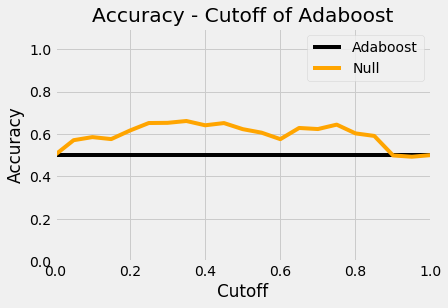

In [22]:
# Acc Curve by cutoff
# ===========================================================
# matplotlib.use('TkAgg')
fig = plt.figure()
plt.xlabel('Cutoff')
plt.ylabel('Accuracy')
plt.title('Accuracy - Cutoff of Adaboost')
plt.plot(np.arange(0, 1.1, 0.1), [0.5 for i in np.arange(0, 1.1, 0.1)], color='black')
plt.plot(ROC.column('CUTOFF'), ROC.column('ACC'), color='orange')
plt.legend(['Adaboost', 'Null'])
plt.axis([0, 1, 0, 1.1])
plt.show()
fig.savefig('Adaboost ACC.png', bbox_inches='tight')

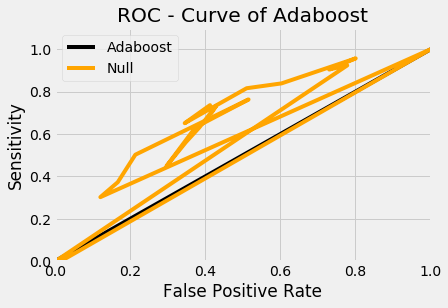

In [23]:
# ROC_CURVE
# ===========================================================
fig = plt.figure()
plt.xlabel('False Positive Rate')
plt.ylabel('Sensitivity')
plt.title('ROC - Curve of Adaboost')
plt.plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), color='black')
plt.plot(ROC.column('FPR'), ROC.column('SENSITIVITY'), color='orange')

plt.legend(['Adaboost', 'Null'])
plt.axis([0, 1, 0, 1.1])
plt.show()
fig.savefig('Adaboost ROC.png', bbox_inches='tight')

In [21]:
# Compute AUC
# ===========================================================
length = len(ROC.column('FPR'))
auc = 0
for i in range(length - 1):
    auc += 0.5 * abs(ROC.column('FPR')[i + 1] - ROC.column('FPR')[i]) * (ROC.column('SENSITIVITY')[i] + ROC.column('SENSITIVITY')[i + 1])
print("auc = %.03f" %auc)

auc = 2.412


In [17]:
fpr, sen, acc = ROC.column('FPR'), ROC.column('SENSITIVITY'), ROC.column('ACC')

In [24]:
sorted(fpr)

[0.0017452006980781037,
 0.01959071624654406,
 0.021771037181969457,
 0.12116296481142855,
 0.16745695033670147,
 0.21425006239054872,
 0.2968555028696071,
 0.34560378062387065,
 0.3486398802091981,
 0.3742201147986346,
 0.3843181251553424,
 0.41290242076314837,
 0.41677065135959973,
 0.4293735962061026,
 0.5103842805614844,
 0.5154729223851816,
 0.6032831737338599,
 0.7298843427425322,
 0.7780126849884617,
 0.800522323093147,
 0.9999999999987522]

In [25]:
sorted(sen)

[0.0005013787916764836,
 0.0015337423312863834,
 0.004132231404953503,
 0.30252942649598985,
 0.37290257951368283,
 0.4482844978707134,
 0.5026296018025261,
 0.5616078136732261,
 0.6306091752310973,
 0.6317305284239523,
 0.6513381078016693,
 0.6997245179054599,
 0.7332832456790217,
 0.7362885048826242,
 0.7632106185815637,
 0.8160572936288277,
 0.8389244879999511,
 0.9043849729854198,
 0.9237341374532935,
 0.956904133683934,
 0.9999999999987478]

In [20]:
acc

array([0.50075 , 0.571063, 0.585625, 0.57625 , 0.616688, 0.652   ,
       0.652875, 0.661563, 0.641375, 0.651813, 0.623125, 0.606563,
       0.575937, 0.62875 , 0.623625, 0.644437, 0.603125, 0.591187,
       0.499125, 0.493125, 0.500625])